In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data

In [5]:
start = '2010-01-01'
end = '2023-12-10'
import yfinance as yfin


yfin.pdr_override()

df = data.data.get_data_yahoo('GOOG',start,end)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.615220,15.678981,15.547723,15.610239,15.610239,78541293
2010-01-05,15.620949,15.637387,15.480475,15.541497,15.541497,120638494
2010-01-06,15.588072,15.588072,15.102393,15.149715,15.149715,159744526
2010-01-07,15.178109,15.193053,14.760922,14.797037,14.797037,257533695
2010-01-08,14.744733,15.024933,14.672753,14.994298,14.994298,189680313


In [6]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.615220,15.678981,15.547723,15.610239,15.610239,78541293
1,2010-01-05,15.620949,15.637387,15.480475,15.541497,15.541497,120638494
2,2010-01-06,15.588072,15.588072,15.102393,15.149715,15.149715,159744526
3,2010-01-07,15.178109,15.193053,14.760922,14.797037,14.797037,257533695
4,2010-01-08,14.744733,15.024933,14.672753,14.994298,14.994298,189680313


In [7]:
df = df.drop(['Date','Adj Close'],axis=1)
df.head()

,Open,High,Low,Close,Volume
0,15.615220,15.678981,15.547723,15.610239,78541293
1,15.620949,15.637387,15.480475,15.541497,120638494
2,15.588072,15.588072,15.102393,15.149715,159744526
3,15.178109,15.193053,14.760922,14.797037,257533695
4,14.744733,15.024933,14.672753,14.994298,189680313


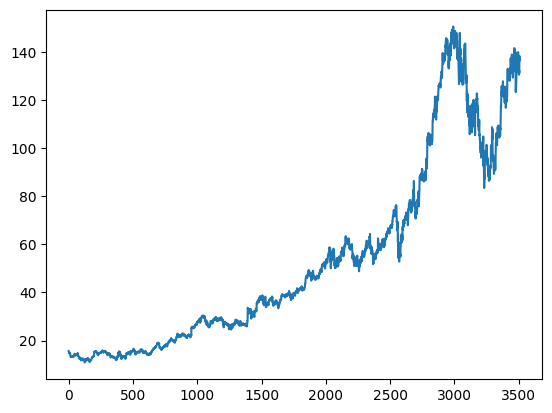

In [8]:
plt.plot(df['Close'])

In [9]:
ma100 = df.Close.rolling(100).mean()

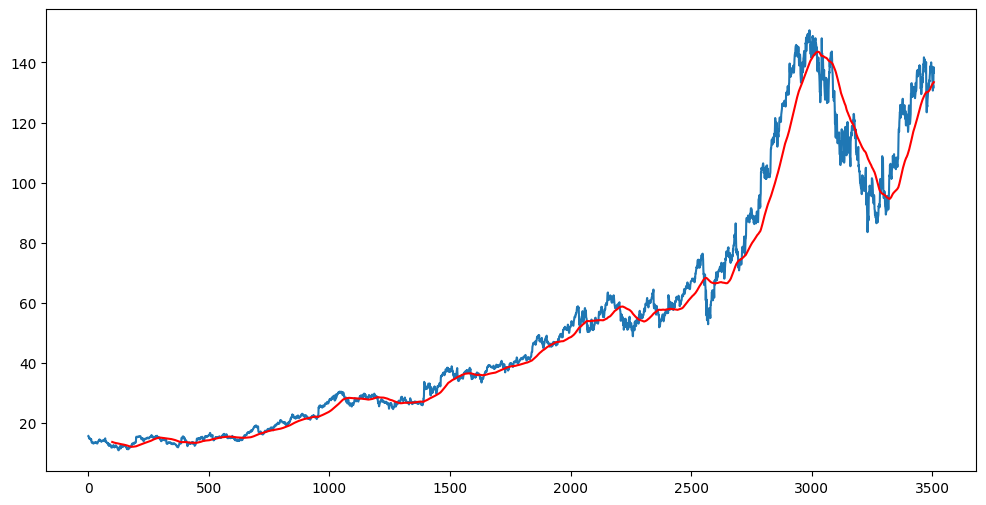

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')

In [11]:
ma200 = df.Close.rolling(200).mean()

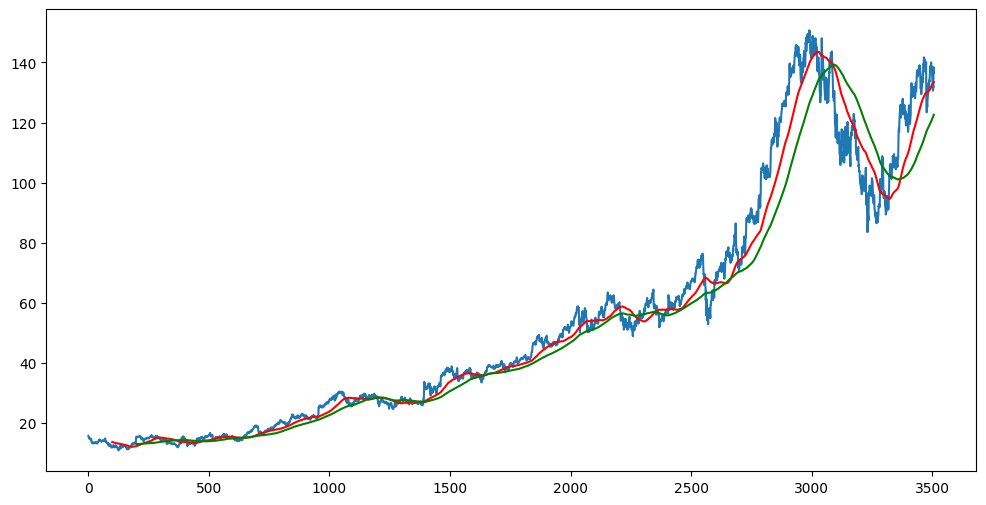

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [13]:
df.shape

(3508, 5)

In [14]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.7)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.7):])

In [15]:
data_training.head()

,Close
0,15.610239
1,15.541497
2,15.149715
3,14.797037
4,14.994298


In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler(feature_range=(-1, 1))

In [17]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[-0.82251943],
       [-0.82508835],
       [-0.83972949],
       ...,
       [ 0.84588363],
       [ 0.79268653],
       [ 0.81361399]])

In [18]:
x_train = []
y_train = []
for i in range(100,data_training_array.shape[0]):
  x_train.append(data_training_array[i-100:i])
  y_train.append([data_training_array[i,0]])

x_train,y_train = np.array(x_train),np.array(y_train)

In [19]:
x_train.shape,y_train.shape

((2355, 100, 1), (2355, 1))

In [21]:
import torch

In [22]:
x_train  = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

In [23]:
import torch
import torch.nn as nn

In [24]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [25]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = nn.MSELoss()

num_epochs = 100
for epoch in range(num_epochs):
    x_train,y_train = x_train.to(device),y_train.to(device)
    outputs = model(x_train)

    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.4088
Epoch [2/100], Loss: 0.3252
Epoch [3/100], Loss: 0.2659
Epoch [4/100], Loss: 0.2581
Epoch [5/100], Loss: 0.1748
Epoch [6/100], Loss: 0.1376
Epoch [7/100], Loss: 0.0780
Epoch [8/100], Loss: 0.0706
Epoch [9/100], Loss: 0.0461
Epoch [10/100], Loss: 0.0558
Epoch [11/100], Loss: 0.0529
Epoch [12/100], Loss: 0.0304
Epoch [13/100], Loss: 0.0227
Epoch [14/100], Loss: 0.0193
Epoch [15/100], Loss: 0.0137
Epoch [16/100], Loss: 0.0123
Epoch [17/100], Loss: 0.0145
Epoch [18/100], Loss: 0.0166
Epoch [19/100], Loss: 0.0165
Epoch [20/100], Loss: 0.0149
Epoch [21/100], Loss: 0.0133
Epoch [22/100], Loss: 0.0122
Epoch [23/100], Loss: 0.0109
Epoch [24/100], Loss: 0.0087
Epoch [25/100], Loss: 0.0061
Epoch [26/100], Loss: 0.0043
Epoch [27/100], Loss: 0.0036
Epoch [28/100], Loss: 0.0032
Epoch [29/100], Loss: 0.0024
Epoch [30/100], Loss: 0.0020
Epoch [31/100], Loss: 0.0025
Epoch [32/100], Loss: 0.0030
Epoch [33/100], Loss: 0.0027
Epoch [34/100], Loss: 0.0027
Epoch [35/100], Loss: 0

In [26]:
data_testing.head()

,Close
2455,60.450001
2456,60.383999
2457,59.456501
2458,60.115501
2459,60.433498


In [27]:
past_100_days = data_training.tail(100)

In [29]:
final_df = past_100_days._append(data_testing,ignore_index=True)

In [30]:
input_data = scaler.fit_transform(final_df)

In [31]:
x_test = []
y_test = []

for i in range(100,input_data.shape[0]):
  x_test.append(input_data[i-100:i])
  y_test.append([input_data[i,0]])


In [32]:
x_test,y_test = np.array(x_test),np.array(y_test)

In [33]:
x_test = torch.from_numpy(x_test).float()

In [34]:
x_test.to(device)
y_pred = model(x_test)

In [35]:
y_pred.shape,y_test.shape

(torch.Size([1053, 1]), (1053, 1))

In [36]:
y_test.shape

(1053, 1)

In [37]:
y_pred = scaler.inverse_transform(y_pred.detach())
y_test = scaler.inverse_transform(y_test)

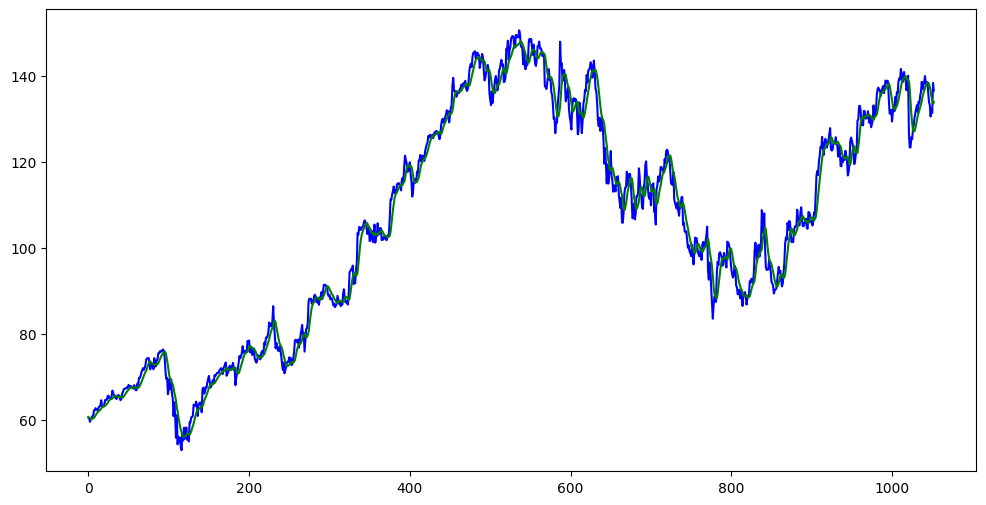

In [38]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b',label='Original Price')
plt.plot(y_pred,'g',label='Predicted Price')

In [39]:
import math
from sklearn.metrics import mean_squared_error
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3.07 RMSE


In [40]:
d = 0
l = []
for i in range(len(y_test)):
  if(abs(y_test[i][0]-y_pred[i][0])>d):
    d = abs(y_test[i][0]-y_pred[i][0])
    l = [y_test[i][0],y_pred[i][0]]

print(d,l)

14.984044969542083 [148.0364990234375, 133.05245405389542]


In [41]:
torch.save(model.state_dict(), "model.pth")